1. Importing necessary Libraries




In [ ]:
# imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns
from matplotlib import pyplot as pl
import numpy as np
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import Birch
from sklearn.cluster import DBSCAN
from sklearn.cluster import MeanShift
from sklearn.cluster import OPTICS

(7050, 16)
   status_id status_type status_published  num_reactions  num_comments  \
0          1       video   4/22/2018 6:00            529           512   
1          2       photo  4/21/2018 22:45            150             0   
2          3       video   4/21/2018 6:17            227           236   
3          4       photo   4/21/2018 2:29            111             0   
4          5       photo   4/18/2018 3:22            213             0   

   num_shares  num_likes  num_loves  num_wows  num_hahas  num_sads  \
0         262        432         92         3          1         1   
1           0        150          0         0          0         0   
2          57        204         21         1          1         0   
3           0        111          0         0          0         0   
4           0        204          9         0          0         0   

   num_angrys  Column1  Column2  Column3  Column4  
0           0      NaN      NaN      NaN      NaN  
1           0      

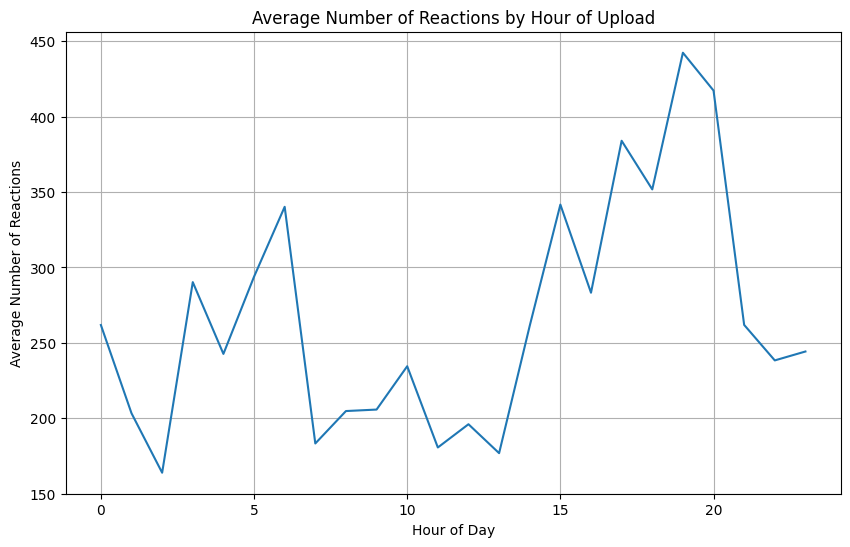

correlation matrix:
               num_reactions  num_comments  num_shares
num_reactions       1.000000      0.150843    0.250723
num_comments        0.150843      1.000000    0.640637
num_shares          0.250723      0.640637    1.000000


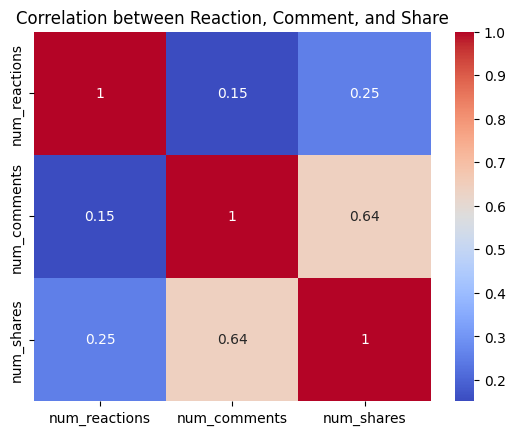

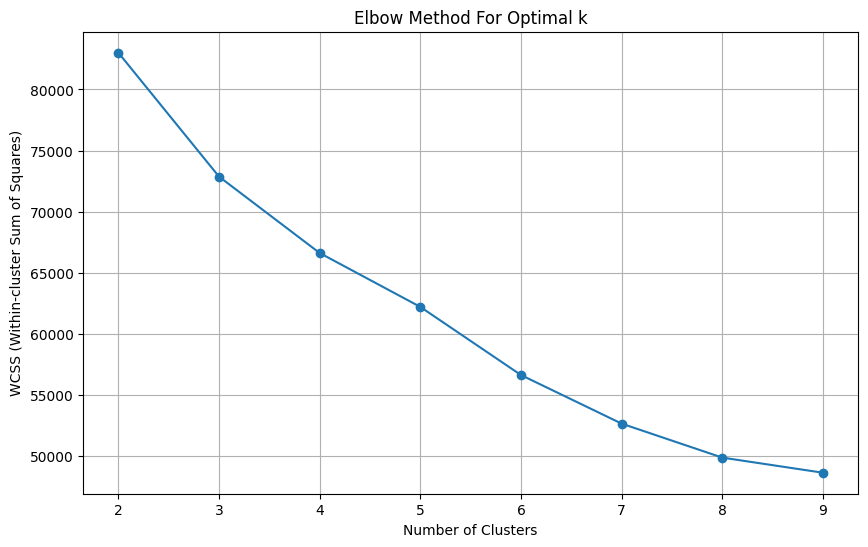

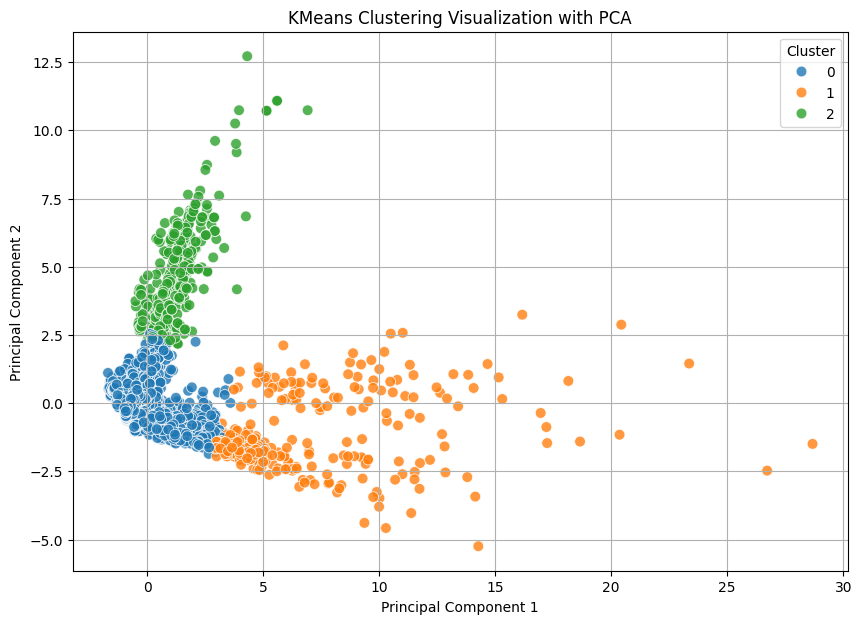

Count of different post types (numerical):
status_type
2    4288
1    2334
3     365
4      63
Name: count, dtype: int64
Average engagement metrics by post type (grouped by numerical status_type):
             num_reactions  num_comments  num_shares
status_type                                         
1               283.409597    642.478149  115.679949
2               181.290345     15.993470    2.553871
3               438.783562     36.238356    2.558904
4               370.142857      5.698413    4.396825


In [24]:
# imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns
from matplotlib import pyplot as pl
import numpy as np
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import Birch
from sklearn.cluster import DBSCAN
from sklearn.cluster import MeanShift
from sklearn.cluster import OPTICS
# Import StandardScaler for feature scaling
from sklearn.preprocessing import StandardScaler

# Loading Data
# In a Colab environment, you might need to upload the file if not mounted or already present
# from google.colab import files
# uploaded = files.upload() # Uncomment if you need to upload the file

import pandas as pd

# Ensure the filename matches your uploaded file
data = pd.read_csv('/Facebook_Marketplace_data.csv')
# Check the shape of the data loaded
print(data.shape)

# First 5 rows of the Dataframe
print(data.head())

# Drop unnecessary columns from the initial load
# Make sure these columns exist in your CSV or adjust as needed
# If these columns don't exist, this line will cause an error, so check your data
try:
    data = data.drop(columns=['Column1', 'Column2', 'Column3', 'Column4'])
except KeyError:
    print("Warning: Some columns ('Column1', 'Column2', 'Column3', 'Column4') not found. Skipping drop.")
    pass # Or handle the error appropriately if these columns are expected

# Data Cleaning
# Discover the amount of data missing
missing = data.isnull().sum()
print('Missing values:')
print(missing)

# show the dataset
print(data.head())
data.info()

# Convert 'status_published' to datetime and extract hour
# Turn the status_published feature into datetime
data['status_published'] = pd.to_datetime(data['status_published'])

# Creation of 4 new features: Year, Month, Day, Hour
data['Year'] = data['status_published'].dt.year
data['Month'] = data['status_published'].dt.month
data['Day'] = data['status_published'].dt.day
data['Hour'] = data['status_published'].dt.hour

# Drop status_ID column since it's not gonna be used for analytics or for clustering
# Check if 'status_id' exists before dropping
if 'status_id' in data.columns:
    data = data.drop(['status_id'], axis=1)
else:
    print("Warning: 'status_id' column not found. Skipping drop.")


# Analyze how time of upload affects num_reactions
avg_reaction_by_Hour = data.groupby('Hour')['num_reactions'].mean()
plt.figure(figsize=(10, 6))
sns.lineplot(x=avg_reaction_by_Hour.index, y=avg_reaction_by_Hour.values)
plt.title('Average Number of Reactions by Hour of Upload')
plt.xlabel('Hour of Day')
plt.ylabel('Average Number of Reactions')
plt.grid(True)
plt.show()

# Correlation between num_reactions, num_comments, and num_shares
correlation = data[['num_reactions', 'num_comments', 'num_shares']].corr()
print('correlation matrix:')
print(correlation)
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation between Reaction, Comment, and Share')
plt.show()

# Drop the Correlated Features - Note: The original code block includes dropping correlated features.
# This part needs careful consideration based on actual correlation values and your goals.
# The original code then proceeds to transform status_type and drop status_published.
# Let's assume you intended to keep the numerical features and the transformed status_type for clustering.

# Dictionary with the key as type of the post and value as dummy so the values can be used in the clusters algorithms.
s_type = {'video': 1,'photo': 2, 'status': 3,'link': 4}

# Transform the post type into numbers so we can analyse them via cluster
# Apply mapping carefully, handling potential NaNs or types not in s_type if necessary
# Using .loc with .isin() is a safer way to apply mapping to existing values
data['status_type'] = data['status_type'].apply(lambda x: s_type.get(x, x)) # .get(x, x) returns x if x is not in s_type

# Drop status_published after datetime features are extracted
# Check if 'status_published' exists before dropping
if 'status_published' in data.columns:
    data = data.drop('status_published', axis=1)
else:
    print("Warning: 'status_published' column not found. Skipping drop.")


# KMeans
#   - In this algorithm the Clusters are well delimited
#   - For this reason it is a good algorithm

# Step 1: Prepare feature matrix X (drop target if exists)
# Ensure X contains only numerical columns suitable for clustering
# It's good practice to explicitly select columns or drop non-numeric ones
X = data.select_dtypes(include=np.number).copy() # Select only numerical columns

# Fill NaNs with 0 (if any) - or consider other imputation strategies
X.fillna(0, inplace=True)

# Step 2: Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Elbow method to find optimal number of clusters
wcss = []
for k in range(2, 10):
    # Use n_init='auto' or a specific number for KMeans 1.1 and later
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto') # Changed n_init=10 to 'auto' for modern KMeans versions
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10,6))
plt.plot(range(2, 10), wcss, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-cluster Sum of Squares)')
plt.grid(True)
plt.show()


# Step 5: Choose best k (example: 3) - Based on Elbow and Silhouette results, choose your k
optimal_k = 3 # Example choice, adjust based on previous steps
# Use n_init='auto'
# Changed n_init='10' to n_init=10 (integer) or n_init='auto' (string)
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10) # Changed '10' to 10 (integer) or use 'auto'
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels to original data
# Ensure data has the same number of rows as X_scaled after preprocessing
data['Cluster'] = clusters

# Step 6: PCA for visualization
# You need to import PCA if not already done
from sklearn.decomposition import PCA
pca = PCA(n_components=2) # Initialize PCA

# Fit and transform using the scaled data X_scaled
pca_result = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2'])
# Make sure pca_df and data have compatible indices or reset indices if needed
pca_df['Cluster'] = data['Cluster'].reset_index(drop=True) # Add Cluster from data, aligning indices

# Step 7: Plot PCA results colored by cluster
plt.figure(figsize=(10,7))
palette = sns.color_palette('tab10', n_colors=optimal_k)
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=pca_df, palette=palette, s=60, alpha=0.8)
plt.title('KMeans Clustering Visualization with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

# (v) Count of different types of posts
# Assuming 'status_type' is now numerical after mapping, convert back or use original data if available
# If you dropped 'status_published' and transformed 'status_type' in the data variable, use the transformed one.
# If you need the original labels, you might need to load data again or save the original 'status_type'.
# Let's use the mapped numerical 'status_type' for consistency with the current 'data' state.
# If you want the original counts, you'd need the data *before* the mapping step.
post_type_counts = data['status_type'].value_counts()
print('Count of different post types (numerical):')
print(post_type_counts)

# Step 10: Average num_reactions, num_comments, num_shares by post type
# Grouping by the numerical 'status_type'
avg_engagement_by_type = data.groupby('status_type')[['num_reactions', 'num_comments', 'num_shares']].mean()
print('Average engagement metrics by post type (grouped by numerical status_type):')
print(avg_engagement_by_type)

# New Section